# Moment that we have all been wating for: KANs

Let us firstly rewrite the function fitting to pyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
def basis_function(i, p, t, x):
    if p == 0:  # Base case: degree 0
        return torch.where((t[i] <= x) & (x < t[i + 1]), 1.0, 0.0)
    else:
        # Recursive definition with torch operations
        left_num = x - t[i]
        left_den = t[i + p] - t[i]
        left = (left_num / left_den) * basis_function(i, p - 1, t, x) if left_den != 0 else 0.0

        right_num = t[i + p + 1] - x
        right_den = t[i + p + 1] - t[i + 1]
        right = (right_num / right_den) * basis_function(i + 1, p - 1, t, x) if right_den != 0 else 0.0

        return left + right

Knot vector: [-1.         -1.         -1.         -1.         -0.93103448 -0.86206897
 -0.79310345 -0.72413793 -0.65517241 -0.5862069  -0.51724138 -0.44827586
 -0.37931034 -0.31034483 -0.24137931 -0.17241379 -0.10344828 -0.03448276
  0.03448276  0.10344828  0.17241379  0.24137931  0.31034483  0.37931034
  0.44827586  0.51724138  0.5862069   0.65517241  0.72413793  0.79310345
  0.86206897  0.93103448  1.          1.          1.          1.        ]
Coefficients: tensor([[-0.4993],
        [-0.4917],
        [-0.4491],
        [-0.5032],
        [-0.6286],
        [-0.4207],
        [-0.2531],
        [-0.7945],
        [-0.8275],
        [ 0.1843],
        [-0.2785],
        [-1.6445],
        [-0.3215],
        [ 0.9284],
        [-1.2926],
        [-1.7885],
        [ 0.7801],
        [ 0.3226],
        [-1.9810],
        [-0.3033],
        [ 1.7046],
        [ 0.2360],
        [-0.1662],
        [ 0.8237],
        [ 0.7855],
        [ 0.2785],
        [ 0.3687],
        [ 0.7288],
  

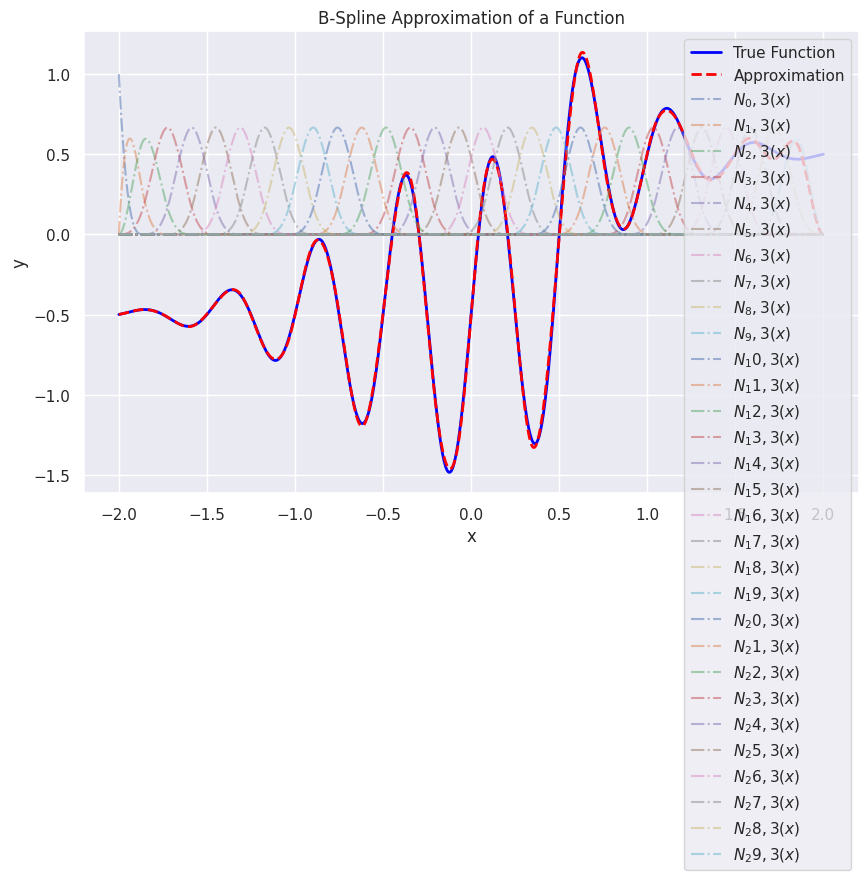

In [97]:
n_control_points = 30
k = 3
t = np.linspace(-1, 1, num=n_control_points)
t = np.pad(t, (k, k), mode='edge')
t_values = np.linspace(t[0], t[-1], 1000)

x_values = torch.linspace(-2, 2, 1000)
t_tensor = torch.tensor(t, dtype=torch.float32)
t_values_tensor = torch.tensor(t_values, dtype=torch.float32)

print("Knot vector:", t)

# Precompute basis functions
bfs = torch.zeros((len(t_values), n_control_points), dtype=torch.float32)
for i in range(n_control_points):
    bfs[:, i] = basis_function(i, k, t_tensor, t_values_tensor)

# Function to approximate
fn = lambda x: (
    torch.sin(4 * np.pi * x_values) * torch.exp(-x_values**2)  # Oscillatory and decaying
    + 0.5 * torch.tanh(10 * x_values - 5)  # Sharp transition
)
fn_values = fn(x_values)


# Solve for coefficients using lstsq
coeffs = torch.linalg.lstsq(bfs, fn_values.unsqueeze(1))
coeffs = coeffs.solution
print("Coefficients:", coeffs)

# Compute predicted values
y_pred = torch.matmul(bfs, coeffs)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), fn_values.numpy(), label="True Function", color='blue', linewidth=2)
plt.plot(x_values.numpy(), y_pred.numpy(), label="Approximation", color='red', linewidth=2, linestyle='--')
for i in range(bfs.shape[1]):
    plt.plot(x_values.numpy(), bfs[:, i].numpy(), label=f'$N_{i},{k}(x)$', linestyle='-.', alpha=0.5)
plt.title("B-Spline Approximation of a Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [91]:
x_values = torch.linspace(-2, 2, steps=1000)
fn = lambda x: torch.sin(-2 * np.pi * x)
fn = lambda x: (
    torch.sin(4 * np.pi * x_values) * torch.exp(-x_values**2)  # Oscillatory and decaying
    + 0.5 * torch.tanh(10 * x_values - 5)  # Sharp transition
)
fn_values = fn(x_values)

In [92]:
def basis_function(i, p, t, x):
    if p == 0:
        # Degree 0
        return torch.where((t[i] <= x) & (x < t[i + 1]), torch.ones_like(x), torch.zeros_like(x))
    else:
        # Recursive definition
        left_num = x - t[i]
        left_den = t[i + p] - t[i]
        left = (left_num / left_den) * basis_function(i, p - 1, t, x) if left_den != 0 else torch.zeros_like(x)
        
        right_num = t[i + p + 1] - x
        right_den = t[i + p + 1] - t[i + 1]
        right = (right_num / right_den) * basis_function(i + 1, p - 1, t, x) if right_den != 0 else torch.zeros_like(x)
        
        return left + right

In [93]:
class BSplineLayer(nn.Module):
    def __init__(self, degree, n_control_points):
        super(BSplineLayer, self).__init__()
        self.degree = degree
        self.n_control_points = n_control_points
        self.num_basis = n_control_points
        self.weights = nn.Parameter(torch.randn(self.num_basis))  # Trainable weights
        self.scale = nn.Parameter(torch.tensor(1.0)) # Trainable scaling factor
        self.shift = nn.Parameter(torch.tensor(0.0)) # Trainable shift factor

    def prepare_knots(self, min_val, max_val):
        knot_vector = np.linspace(min_val, max_val, num=self.n_control_points) 
        knot_vector = np.pad(knot_vector, (self.degree, self.degree), mode='edge')
        self.knot_vector = torch.tensor(knot_vector, dtype=torch.float32)
        self.knot_vector.requires_grad = False

    def prepare_bases(self, x_size):
        N = []
        for i in range(self.num_basis):
            N_i = basis_function(i, self.degree, self.knot_vector, torch.linspace(self.knot_vector[0], self.knot_vector[-1], steps=x_size))
            N.append(N_i)
        self.N = torch.stack(N, dim=1)


    def forward(self, x):
        # Compute basis functions
        self.prepare_knots(x.min().item(), x.max().item())
        self.prepare_bases(x.size(0))
        output = self.N @ self.weights 
        output = output * self.scale + self.shift
        return output
    

class BSplineNet(nn.Module):
    def __init__(self, n_layers):
        super(BSplineNet, self).__init__()
        self.layers = nn.ModuleList([BSplineLayer(degree=3, n_control_points=14) for _ in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

Epoch [100/1000], Loss: 0.282973
Epoch [200/1000], Loss: 0.204354
Epoch [300/1000], Loss: 0.181516
Epoch [400/1000], Loss: 0.175256
Epoch [500/1000], Loss: 0.171370
Epoch [600/1000], Loss: 0.168532
Epoch [700/1000], Loss: 0.166606
Epoch [800/1000], Loss: 0.165424
Epoch [900/1000], Loss: 0.164743
Epoch [1000/1000], Loss: 0.164359


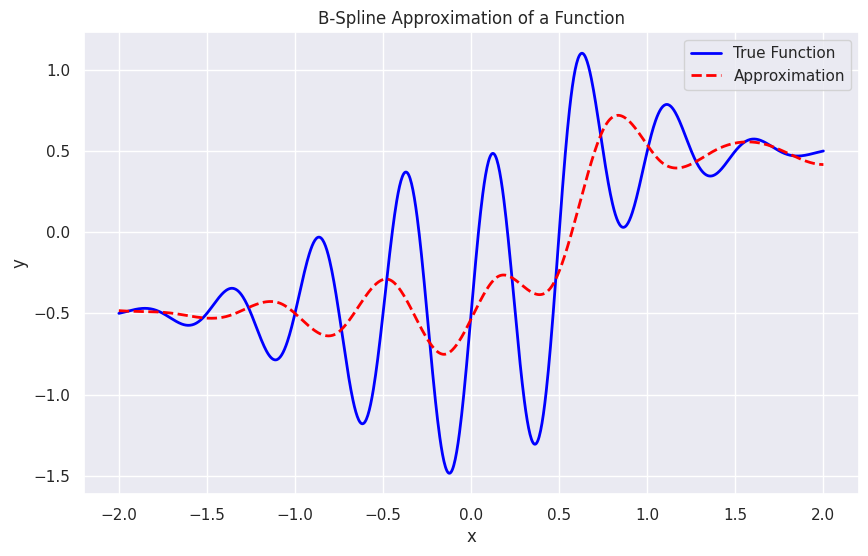

In [95]:
model = BSplineNet(n_layers=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_values)
    loss = criterion(outputs, fn_values)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
k# Compute predicted values
y_pred = model(x_values).detach()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), fn_values.numpy(), label="True Function", color='blue', linewidth=2)
plt.plot(x_values.numpy(), y_pred.numpy(), label="Approximation", color='red', linewidth=2, linestyle='--')
plt.title("B-Spline Approximation of a Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()